In [ ]:
Q1 = pd.read_csv('hosthome/loanstats/LoanStats_2016Q1.csv', skiprows=1)
Q2 = pd.read_csv('hosthome/loanstats/LoanStats_2016Q2.csv', skiprows=1)
Q3 = pd.read_csv('hosthome/loanstats/LoanStats_2016Q3.csv', skiprows=1)
Q4 = pd.read_csv('hosthome/loanstats/LoanStats_2016Q4.csv', skiprows=1)

In [ ]:
# Nan 값인 컬럼 지우기
pd.options.display.max_rows = 125
Q1.drop(Q1.columns[Q1.isnull().sum() >= 130000].tolist(), axis=1, inplace=True)
Q2.drop(Q2.columns[Q2.isnull().sum() >= 90000].tolist(), axis=1, inplace=True)
Q3.drop(Q3.columns[Q3.isnull().sum() >= 90000].tolist(), axis=1, inplace=True)
Q4.drop(Q4.columns[Q4.isnull().sum() >= 90000].tolist(), axis=1, inplace=True)

In [ ]:
# 데이터 결합
df0 = pd.concat([Q1, Q2, Q3, Q4], axis=0)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd

df0 = pd.read_csv('lcdf2.csv')

In [2]:
# 신청 타입 개인으로 한정
df0.drop(df0.application_type[df0.application_type != 'INDIVIDUAL'].index, axis=0, inplace=True)

In [3]:
# 이자율 실수타입으로 변경
def p2f(x):
    return float(x.strip('%'))/100

df0['int_rate'] = df0.int_rate.map(p2f)

In [ ]:
pd.options.display.max_columns = 110
df0.loc[(df0.annual_inc >= 1000000), :].head()

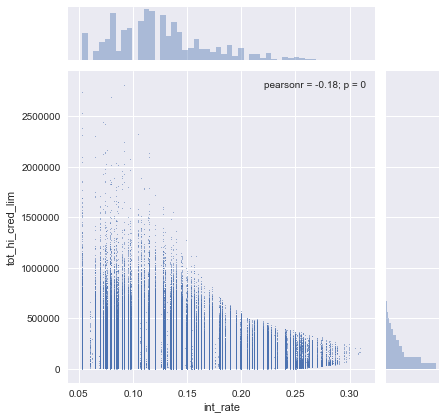

In [87]:
import seaborn as sns
import matplotlib as mlt
import matplotlib.pyplot as plt
sns.jointplot('int_rate', 'tot_hi_cred_lim', data=df1, s=0.2)
plt.show()

In [ ]:
def pearsonr2(df):
    returns = pd.Series([0])
    for i in df.columns:
        if i == 'int_rate':
            continue
        else:
            try:
                returns[i] = sp.stats.pearsonr(df[i], df.int_rate)[0]
            except:
                continue
    return returns

In [34]:
# 한도 위주 모형
import statsmodels.api as sm
model = sm.OLS.from_formula('int_rate ~ tot_hi_cred_lim + total_il_high_credit_limit + total_bc_limit', df0)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     7483.
Date:                Sat, 08 Jul 2017   Prob (F-statistic):               0.00
Time:                        16:35:48   Log-Likelihood:             6.8549e+05
No. Observations:              422724   AIC:                        -1.371e+06
Df Residuals:                  422720   BIC:                        -1.371e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

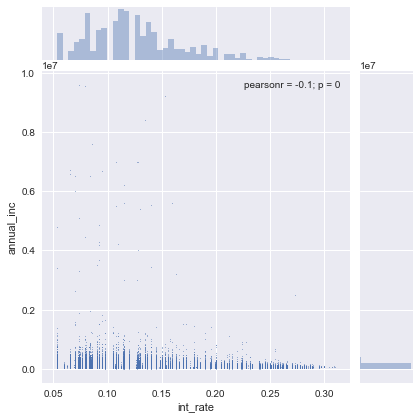

In [35]:
# 연수입과 대출 이자율의 관계
sns.jointplot('int_rate', 'annual_inc', data=df1, s=0.2)
plt.show()

In [30]:
# Fox' recommendation에 따라 특이점 제거, 그래도 모형은 망함
df1 = df0.iloc[np.array(result.get_influence().cooks_distance)[0] < (4 / (df0.shape[0] - df0.shape[1] - 1)), :]

In [88]:
#연체 위주 모형 
model1 = sm.OLS.from_formula('int_rate ~ annual_inc + dti + delinq_2yrs + bc_util + num_sats + pct_tl_nvr_dlq', df0)
result1 = model1.fit()
print(result1.summary())
len(df0)

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     6235.
Date:                Sat, 08 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:49:16   Log-Likelihood:             6.8559e+05
No. Observations:              418039   AIC:                        -1.371e+06
Df Residuals:                  418032   BIC:                        -1.371e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1217      0.001    140.

422724

In [89]:
# 특이점 제거(약 25k 제거)
df2 = df0.iloc[np.array(result1.get_influence().cooks_distance[0] < (4 / (df0.shape[0] - df0.shape[1] - 1))), :]
len(df2.index)

398774

In [50]:
# 특이점 제거 후 모형(bc_util에서 4천개가 비어있었음)
model2 = sm.OLS.from_formula('int_rate ~ annual_inc + dti + delinq_2yrs + bc_util + num_sats + pct_tl_nvr_dlq', df2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     7097.
Date:                Sat, 08 Jul 2017   Prob (F-statistic):               0.00
Time:                        18:23:34   Log-Likelihood:             6.4691e+05
No. Observations:              394377   AIC:                        -1.294e+06
Df Residuals:                  394371   BIC:                        -1.294e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1247      0.001    158.

In [66]:
# delinq_2yrs 제거한 모형
model3 = sm.OLS.from_formula('int_rate ~ I(annual_inc / 1000000) + dti + bc_util + num_sats + pct_tl_nvr_dlq', df2)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     7097.
Date:                Sat, 08 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:16:31   Log-Likelihood:             6.4691e+05
No. Observations:              394377   AIC:                        -1.294e+06
Df Residuals:                  394371   BIC:                        -1.294e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [82]:
# 교차검증 실시(bc_util의 비어있는 값 전부 제거)
df3X = df2.loc[:, ['annual_inc', 'dti', 'bc_util', 'num_sats', 'pct_tl_nvr_dlq']]
df3X = sm.add_constant(df3X)
df3X.annual_inc = df3X.annual_inc / (10 * 6)
df3y = df2[['int_rate']]
df3y.drop(df3X.bc_util[df3X.bc_util.isnull()].index, inplace=True)
df3X.drop(df3X.bc_util[df3X.bc_util.isnull()].index, inplace=True)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
cross_val_score(LinearRegression(), df3X, df3y, scoring='neg_mean_squared_error', cv=10)


C:\Users\Ryoo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


array([-0.0022538 , -0.00203404, -0.00194473, -0.00213673, -0.00204167,
       -0.00242174, -0.00230067, -0.00227632, -0.00238601, -0.0023228 ])

In [90]:
# 분산 분석
sms.anova_lm(result3)

C:\Users\Ryoo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Ryoo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Ryoo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
I(annual_inc / 1000000),1.0,6.347538,6.347538,2883.003773,0.000000e+00
dti,1.0,39.265722,39.265722,17834.192528,0.000000e+00
bc_util,1.0,28.878861,28.878861,13116.559145,0.000000e+00
num_sats,1.0,0.685801,0.685801,311.485747,1.102645e-69
pct_tl_nvr_dlq,1.0,2.944836,2.944836,1337.522208,2.462348e-292
Residual,394371.0,868.290609,0.002202,NaN,NaN


In [91]:
# num_stat 제거한 모형
df3 = pd.concat([df3X, df3y], axis=1)
model4 = sm.OLS.from_formula('int_rate ~ annual_inc + dti + bc_util + pct_tl_nvr_dlq', df3)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     8810.
Date:                Sat, 08 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:57:02   Log-Likelihood:             6.4680e+05
No. Observations:              394377   AIC:                        -1.294e+06
Df Residuals:                  394372   BIC:                        -1.294e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1238      0.001    157.